In [1]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 100kB/s 
ERROR: tensorflow 2.2.0rc3 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# Neural style transfer


![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```

## The content loss

## The style loss

## Neural style transfer in Keras


Neural style transfer can be implemented using any pre-trained convnet. Here we will use the VGG19 network, used by Gatys et al in their paper. 
VGG19 is a simple variant of the VGG16 network we introduced in Chapter 5, with three more convolutional layers.

This is our general process:

* Set up a network that will compute VGG19 layer activations for the style reference image, the target image, and the generated image at 
the same time.
* Use the layer activations computed over these three images to define the loss function described above, which we will minimize in order 
to achieve style transfer.
* Set up a gradient descent process to minimize this loss function.


Let's start by defining the paths to the two images we consider: the style reference image and the target image. To make sure that all 
images processed share similar sizes (widely different sizes would make style transfer more difficult), we will later resize them all to a 
shared height of 400px.

In [0]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = './house.jpg'
# This is the path to the style image.
style_reference_image_path = './Irises-Vincent_van_Gogh.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

We will need some auxiliary functions for loading, pre-processing and post-processing the images that will go in and out of the VGG19 
convnet:

In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


Let's set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder 
that will contain the generated image. A placeholder is simply a symbolic tensor, the values of which are provided externally via Numpy 
arrays. The style reference and target image are static, and thus defined using `K.constant`, while the values contained in the placeholder 
of the generated image will change over time.

In [5]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


In [13]:
model.summary() #

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
target_image.shape #

TensorShape([1, 400, 600, 3])

In [15]:
style_reference_image.shape #

TensorShape([1, 400, 600, 3])

In [16]:
combination_image.shape #

TensorShape([1, 400, 600, 3])


Let's define the content loss, meant to make sure that the top layer of the VGG19 convnet will have a similar view of the target image and 
the generated image:

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


Now, here's the style loss. It leverages an auxiliary function to compute the Gram matrix of an input matrix, i.e. a map of the correlations 
found in the original feature matrix.

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


To these two loss components, we add a third one, the "total variation loss". It is meant to encourage spatial continuity in the generated 
image, thus avoiding overly pixelated results. You could interpret it as a regularization loss.

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


The loss that we minimize is a weighted average of these three losses. To compute the content loss, we only leverage one top layer, the 
`block5_conv2` layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total 
variation loss at the end.

Depending on the style reference image and content image you are using, you will likely want to tune the `content_weight` coefficient, the 
contribution of the content loss to the total loss. A higher `content_weight` means that the target content will be more recognizable in 
the generated image.

In [0]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)


Finally, we set up the gradient descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, 
so that is also what we will use here. This is a key difference from the Deep Dream example in the previous section. The L-BFGS algorithms 
comes packaged with SciPy. However, there are two slight limitations with the SciPy implementation:

* It requires to be passed the value of the loss function and the value of the gradients as two separate functions.
* It can only be applied to flat vectors, whereas we have a 3D image array.

It would be very inefficient for us to compute the value of the loss function and the value of gradients independently, since it would lead 
to a lot of redundant computation between the two. We would be almost twice slower than we could be by computing them jointly. To by-pass 
this, we set up a Python class named `Evaluator` that will compute both loss value and gradients value at once, will return the loss value 
when called the first time, and will cache the gradients for the next call.

In [0]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


Finally, we can run the gradient ascent process using SciPy's L-BFGS algorithm, saving the current generated image at each iteration of the 
algorithm (here, a single iteration represents 20 steps of gradient ascent):

In [11]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1220673200.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 28s
Start of iteration 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 516615800.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 17s
Start of iteration 2
Current loss value: 368298200.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 17s
Start of iteration 3
Current loss value: 285799260.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 17s
Start of iteration 4
Current loss value: 245196900.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 17s
Start of iteration 5
Current loss value: 219324060.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 17s
Start of iteration 6
Current loss value: 198802420.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 17s
Start of iteration 7
Current loss value: 182181900.0
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 17s
Start of iteration 8
Current loss value: 169235120.0
Im

Here's what we get:

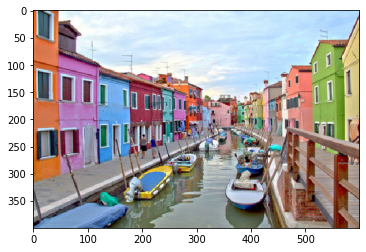

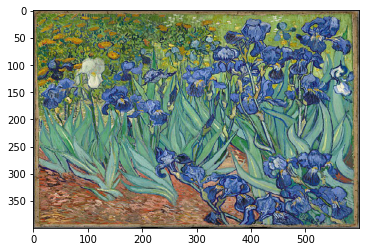

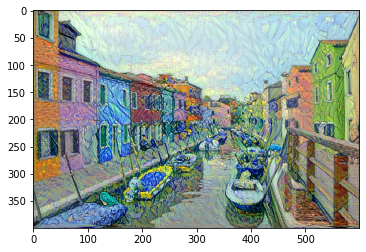

In [12]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()